In [1]:
#https://www.jianshu.com/p/e79a8c41cb1a  使用的是这个方案
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import precision_score, recall_score,accuracy_score,f1_score,roc_auc_score,mean_squared_error
from sklearn.metrics import log_loss

train=pd.read_csv(r'D:\书籍资料整理\kaggle\titanic\train.csv')
test=pd.read_csv(r'D:\书籍资料整理\kaggle\titanic\test.csv')
PassengerId=test['PassengerId']
all_data=pd.concat([train,test],axis=0,ignore_index=True)
#可以看到age是有空值的，并且明显Cabin空值较多,房间号被排除了不包含什么信息
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [2]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

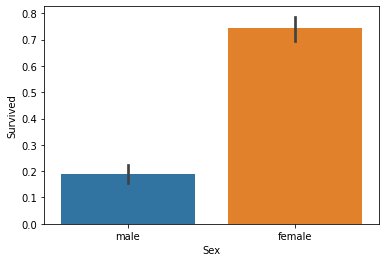

In [3]:
sns.barplot(x="Sex", y="Survived", data=train)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

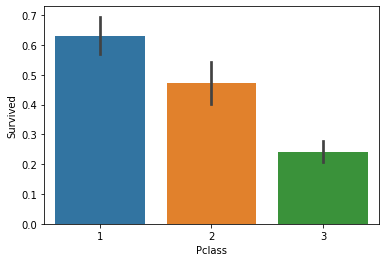

In [4]:
sns.barplot(x="Pclass", y="Survived", data=train)

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

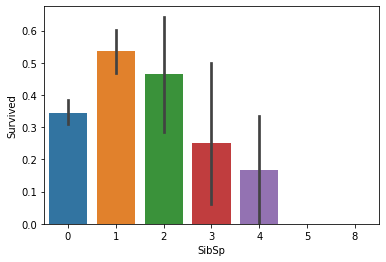

In [5]:
sns.barplot(x="SibSp", y="Survived", data=train)

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

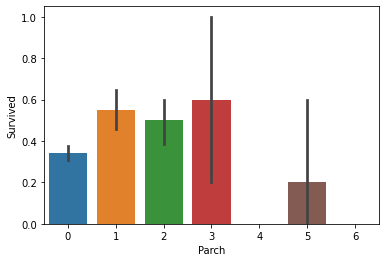

In [6]:
sns.barplot(x="Parch", y="Survived", data=train)

Text(28.04088541666667, 0.5, 'density')

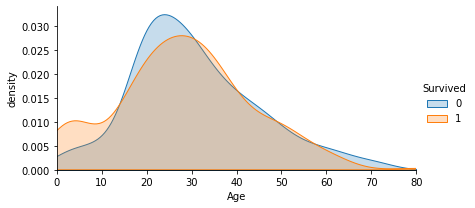

In [7]:
#从不同生还情况的密度图可以看出，在年龄15岁的左侧，生还率有明显差别，
#密度图非交叉区域面积非常大，但在其他年龄段，
#则差别不是很明显，认为是随机所致，因此可以考虑将此年龄偏小的区域分离出来。

#这种方法可以用于给特征分段
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age') 
plt.ylabel('density') 

d:\users\50477\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Embarked', ylabel='count'>

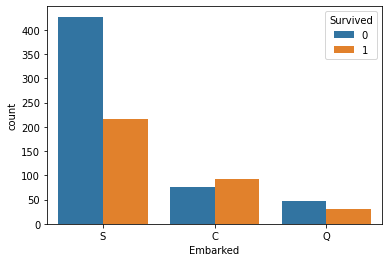

In [8]:
#Embarked登港港口与生存情况的分析
#结果分析:C地的生存率更高,这个也应该保留为模型特征.
sns.countplot('Embarked',hue='Survived',data=train)

<AxesSubplot:xlabel='Title', ylabel='Survived'>

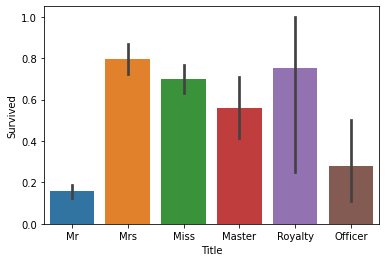

In [9]:
#称呼
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data)

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

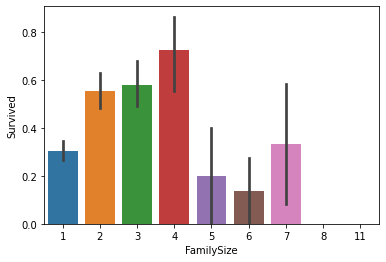

In [10]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data)

<AxesSubplot:xlabel='FamilyLabel', ylabel='Survived'>

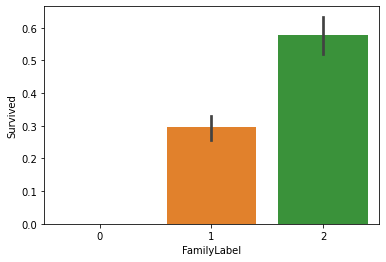

In [11]:
#通过上图看到 基本2 3 4 为一类 1 5 6 7为一类,为防其他的值出现将其他值设为0
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data)

<AxesSubplot:xlabel='Deck', ylabel='Survived'>

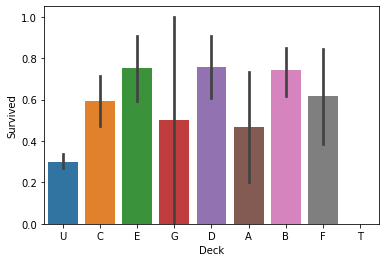

In [12]:
#添加了 甲板号这个特征, 这个是我不可能知道的,并且CaBin缺失很高,这个真的有用?
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data)

<AxesSubplot:xlabel='TicketGroup', ylabel='Survived'>

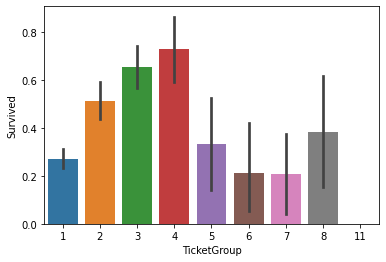

In [13]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

<AxesSubplot:xlabel='TicketGroup', ylabel='Survived'>

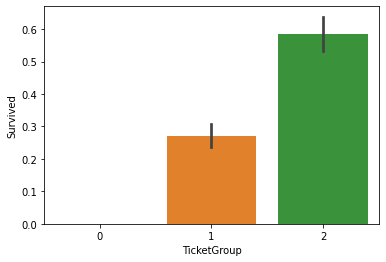

In [14]:
#将ticket_label也分为3类
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

In [15]:
#这里说的是使用y使用的是age
from sklearn.ensemble import RandomForestRegressor
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges

In [16]:
#Embarked缺失值为2,方案中
#Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，
#所以缺失值填充为C。
#但是对这么低的缺失,填充为0不就得了但是先按这个方案坐下来再说
all_data[all_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,1,1,B,2
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,1,1,B,2


In [17]:
all_data.groupby(by=["Pclass","Embarked"]).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [18]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [19]:
#这里fare只缺了一个,不如用0填充我觉得
all_data[all_data['Fare'].isnull()]
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [20]:
#把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [21]:
#绝大部分成年男性组的平均存活率也为1或0。
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5, 0, 'AverageSurvived')

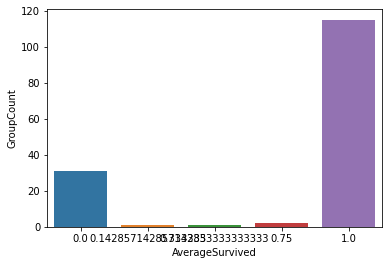

In [22]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"]).set_xlabel('AverageSurvived')

In [23]:
#成年男性大多是0
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [24]:
#将反常组取出
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

#对测试组的数值进行惩罚
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
# test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
# test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
# test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
# test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
# test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
# test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

{'Ford', 'Bourke', 'Panula', 'Strom', 'Turpin', 'Palsson', 'Cacic', 'Ilmakangas', 'Arnold-Franchi', 'Caram', 'Rosblom', 'Johnston', 'Lobb', 'Zabour', 'Robins', 'Danbom', 'Vander Planke', 'Goodwin', 'Lahtinen', 'Jussila', 'Skoog', 'Sage', 'Attalah', 'Canavan', 'Lefebre', 'Boulos', 'Van Impe', 'Barbara', 'Oreskovic', 'Olsson', 'Rice'}
{'Chambers', 'Beckwith', 'Kimball', 'Cardeza', 'Nakid', 'Beane', 'Dick', 'Greenfield', 'McCoy', 'Frolicher-Stehli', 'Goldenberg', 'Daly', 'Jonsson', 'Jussila', 'Frauenthal', 'Duff Gordon', 'Harder', 'Taylor', 'Bishop', 'Bradley'}


In [25]:
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
#Title	TicketGroup
sex=LabelEncoder()
sex.fit(all_data['Sex'])
all_data['Sex']=sex.transform(all_data['Sex'])

Embarked=LabelEncoder()
Embarked.fit(all_data['Embarked'])
all_data['Embarked']=Embarked.transform(all_data['Embarked'])

Title=LabelEncoder()
Title.fit(all_data['Title'])
all_data['Title']=Title.transform(all_data['Title'])

Deck=LabelEncoder()
Deck.fit(all_data['Deck'])
all_data['Deck']=Deck.transform(all_data['Deck'])
all_data.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilyLabel,Deck,TicketGroup
0,0.0,3,1,22.0,7.2500,2,2,2,8,1
1,1.0,1,0,38.0,71.2833,0,3,2,2,2
2,1.0,3,0,26.0,7.9250,2,1,1,8,1
3,1.0,1,0,35.0,53.1000,2,3,2,2,2
4,0.0,3,1,35.0,8.0500,2,2,1,8,1


In [26]:
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.values[:,1:]
y = train.values[:,0]

In [27]:
X=train[[x for x in train.columns if x not in ['Survived','PassengerId']]]
y=train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)
xgb_reg = xgb.XGBClassifier()
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilyLabel,Deck,TicketGroup
568,3,1,28.226256,7.2292,0,2,1,8,1
274,3,0,17.333730,7.7500,1,1,1,8,1
824,3,1,2.000000,39.6875,2,0,1,8,1
588,3,1,22.000000,8.0500,2,2,1,8,1
725,3,1,20.000000,8.6625,2,2,1,8,1


In [28]:
# from sklearn.feature_selection import RFECV
# from sklearn.svm import SVR
# from sklearn.ensemble import GradientBoostingClassifier

# estimator = GradientBoostingClassifier()
# selector = RFECV(estimator, step=1, cv=5)
# selector = selector.fit(X, y)
# print(selector.support_)

# print(selector.ranking_)

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

print(selector.support_)
print(selector.ranking_)

[ True  True  True  True False False False  True False]
[1 1 1 1 3 5 2 1 4]


In [29]:
xgb_param = xgb_reg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)

cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=50, nfold=5,
             metrics={'error'}, seed=0,
             callbacks=[xgb.callback.print_evaluation(show_stdv=False)
                       # ,xgb.callback.early_stop(3)
                       ])
print(cvresult.shape[0])
xgb_reg.set_params(n_estimators=9,max_depth=5)#把clf的参数设置成最好的树对应的参数

d:\users\50477\appdata\local\programs\python\python38\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[0]	train-error:0.13811	test-error:0.19314
[1]	train-error:0.13286	test-error:0.18116
[2]	train-error:0.12463	test-error:0.17818
[3]	train-error:0.12126	test-error:0.18414
[4]	train-error:0.11490	test-error:0.18713
[5]	train-error:0.11789	test-error:0.18862
[6]	train-error:0.11004	test-error:0.18114
[7]	train-error:0.10742	test-error:0.18412
[8]	train-error:0.10368	test-error:0.18262
[9]	train-error:0.10068	test-error:0.17813
[10]	train-error:0.09731	test-error:0.18561
[11]	train-error:0.09319	test-error:0.18262
[12]	train-error:0.08983	test-error:0.18111
[13]	train-error:0.08795	test-error:0.18111
[14]	train-error:0.08459	test-error:0.18111
[15]	train-error:0.08347	test-error:0.17962
[16]	train-error:0.08272	test-error:0.18262
[17]	train-error:0.08122	test-error:0.17963
[18]	train-error:0.07823	test-error:0.17963
[19]	train-error:0.07822	test-error:0.17964
[20]	train-error:0.07373	test-error:0.18114
[21]	train-error:0.07148	test-error:0.18263
[22]	train-error:0.07186	test-error:0.1856

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=9, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [30]:
xgb_reg.fit(X_train, y_train, eval_metric='auc')
y_pred = xgb_reg.predict(X_val)
y_score = xgb_reg.predict_proba(X_val)

d:\users\50477\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [31]:
print('测试集准确率:',accuracy_score(y_val, y_pred))
print('测试集精度:',precision_score(y_val, y_pred))
print('测试集召回率:',recall_score(y_val, y_pred))
print('auc:',roc_auc_score(y_val, y_score[:,1]))

测试集准确率: 0.8430493273542601
测试集精度: 0.759493670886076
测试集召回率: 0.7894736842105263
auc: 0.8909774436090225


In [32]:
log_loss(y_val, y_pred)

5.420952314677344

In [33]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilyLabel,Deck,TicketGroup
0,3,1,22.0,7.2500,2,2,2,8,1
1,1,0,38.0,71.2833,0,3,2,2,2
2,3,0,26.0,7.9250,2,1,1,8,1
3,1,0,35.0,53.1000,2,3,2,2,2
4,3,1,35.0,8.0500,2,2,1,8,1


In [34]:
predictions =xgb_reg.predict(test)
data_test = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
data_test.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [35]:
data_test.to_csv(r'D:\书籍资料整理\kaggle\titanic\output.csv',index=False)

In [36]:
xgb_reg.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 9,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}